### Meshing jupyter notebook

In [1]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *

In [2]:
"""
Order of operation:
 1. make a mesh
 2. make a field / variable T
 3. make kernels that operate on that field for that mesh
"""

'\nOrder of operation:\n 1. make a mesh\n 2. make a field / variable T\n 3. make kernels that operate on that field for that mesh\n'

In [3]:
class FlowChannel:
  """
  Flow channel object for thermal hydraulics - 1D
  mesh: Mesh_1D object representing mesh
  pressure_closure: closure relationship used for pressure loss model
  TH_closure: TH closure used for heat flux calculations
  """
  def __init__(self,
               mesh: Mesh_1D,
               pressure_closure: str, TH_closure: str,
               inlet_loss_coeff: float,
               outlet_loss_coeff: float,
               flow_area: float,
               wall_area: float):
    self.mesh = mesh
    self.pressure_closure = pressure_closure
    self.TH_closure = TH_closure
    self.inlet_loss_coeff = inlet_loss_coeff
    self.outlet_loss_coeff = outlet_loss_coeff

    # we make these vectors in case they vary with height
    self.nz = self.mesh.nz
    self.flow_area = np.ones(self.nz)*flow_area
    self.wall_area = np.ones(self.nz)*wall_area

In [4]:
# initial parameters / user input
nZones = 11
ic = 0.0
Gamma = 0.1
w=1.0
upper_phi = 0
lower_phi = 1
rho=1.0
L0 = 0
L1 = 1
scheme = 'quick'


cell_peclet = rho * w * ((L1-L0)/(nZones-1))/Gamma
print("Cell peclet number is: ", cell_peclet)

coords = np.linspace(L0,L1,nZones)
areas = [1]*nZones

# Make a mesh
mesh = Mesh_1D(nodeCoords=coords, faceAreas=areas)

# Make a field for this scalar
field = ScalarField(name='T', initial_value=ic, mesh=mesh)

# Make a FaceField for the velocity
vel = FaceField(name='w', initial_value=w, mesh=mesh)

# Make some kernels
diff_T = DiffusionKernel(field=field, mesh=mesh, Gamma=Gamma)
adv_T = AdvectionKernel(field=field,mesh=mesh,w=vel,scheme=scheme, rho=rho)

# make some boundary conditions now
upper_bc = DirchletBC(field=field, mesh=mesh, phi=upper_phi, Gamma=Gamma, boundary='upper')
lower_bc = DirchletBC(field=field, mesh=mesh, phi=lower_phi, Gamma=Gamma, boundary='lower')

# now collect everything
bcs = [upper_bc, lower_bc]
kernels = [adv_T, diff_T]

solver = BasicSolver(bcs=bcs, kernels=kernels, field=field)
solver.solve()


Cell peclet number is:  1.0


(0.0, 1.0)

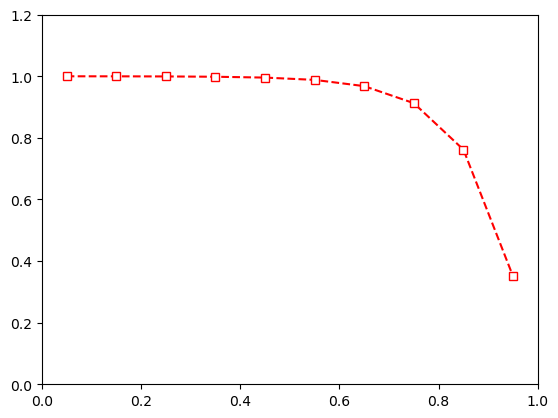

In [5]:
plt.plot(field.centroids, field.T, 'rs--', markerfacecolor='w')
plt.ylim([0,1.2])
plt.xlim([0,1])